## MNIST Handwritten digits classifier

In [1]:
# Import the goodies
%matplotlib inline
%load_ext tensorboard

import numpy as np
import time
import tensorflow as tf
from tensorflow import keras  # import from tensorflow for better support??? I dunno
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score
import seaborn as sns

In [2]:
# Load the data (Automatically downloads from AWS, so no file manpulation needed)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
# Reshape the data
X = x_train.reshape(60000, 28, 28, 1)
y = y_train.reshape(60000, 1)

# Process the data
X = X / 255.0

# Onehot encode y_train
enc = OneHotEncoder().fit(y)
y = enc.transform(y).toarray()

In [45]:
# Format the test dataset (However, no processing is done on the set)
X_ = x_test.reshape(10000, 28, 28, 1)
y_ = enc.transform(y_test.reshape((10000,1))).toarray()

X_ = X_ / 255.0

To find the most ambigious images in the test dataset, we must first build a classifier that gives us the probability of which digit it is

In [29]:
# Build the network
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))  # Filter the data
model.add(layers.MaxPooling2D((2,2)))                                            # Make the view larger; find bigger patterns
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())                                                      # Dimension reduce
model.add(layers.Dropout(0.5))                                                   # Get rid of conspiracies
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # softmax!!!!

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", verbose=1),  # Stop early if training is only going ok
    tf.keras.callbacks.ModelCheckpoint("net1.h5", save_best_only=True, monitor="loss"),
    tf.keras.callbacks.ProgbarLogger(),
#        tf.keras.callbacks.TensorBoard(histogram_freq=1)
]

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)             

In [32]:
# Fit the network
params = {
    'epochs': 100,
    'batch_size': 256,
    'verbose': 0,
    'validation_split': 0.2,
    'callbacks': callbacks
}

tick = time.time()
history = model.fit(X, y,  **params)
print(f'{(time.time()-tick).__round__(2)} seconds to train')    
    
model.save('net1.h5')

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
9.62 seconds to train.


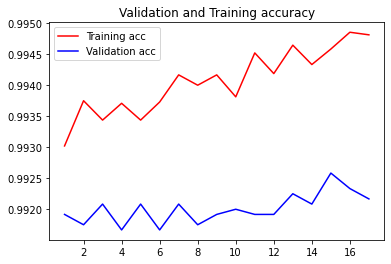

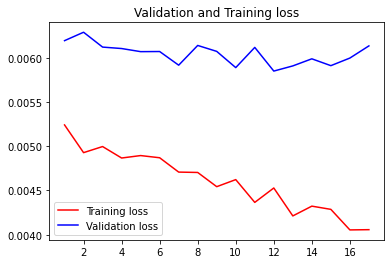

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Validation and Training accuracy')
plt.legend()

plt.figure()  # Combines the two graphs

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Validation and Training loss')
plt.legend()

plt.show()

In [37]:
# How well did the model work?
train_preds = model.predict(X)
print("Training data")
print("Loss", log_loss(y, train_preds))
print("Acc", accuracy_score(y_train, train_preds.argmax(axis=1)))

preds = model.predict(X_)
print("\nTest data:")
print("Loss", log_loss(y_, preds))
print("Acc", accuracy_score(y_test, preds.argmax(axis=1)))

Training data
Loss 0.014555115132692231
Acc 0.9965666666666667

Test data:
Loss 0.026119170409906918
Acc 0.9926


The model ended up with 99.2% accuracy on the test set showing that it fit to the data very well.
It can then provide us with valuable insight one the training data

In [38]:
# Find what the model's predictions actually were
summary = np.zeros((10,10))

for p, truth in zip(preds.copy(), y_test):
    p[truth] = 0  # Remove the correct result
    summary[truth] += p
    #print(p, truth)

row_sums = summary.sum(axis=1)
summary = summary / row_sums[:, np.newaxis]    

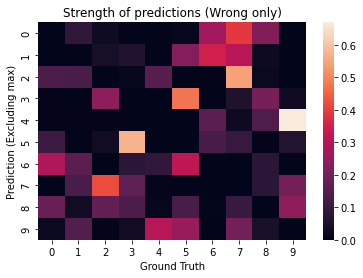

In [39]:
# Add a seaborn plot of 1-10 of classes on each row and how well it classified them
ax = plt.axes()
sns.heatmap(summary, ax=ax)
ax.set_title(f'Strength of predictions (Wrong only)')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction (Excluding max)")
plt.show()

From this plot we can see that often the model predicts a 7 when the ground truth was 2. Likewise this is reflected in how it also predicts a 2 when the ground truth is a 7. However, while these seem significant these results are still excluding all the correct datapoints.

In [40]:
arr = np.vstack((np.arange(0,10000), y_test, preds.argmax(axis=1), np.max(preds, axis=1))).T
# Columns: Index, Truth, Guess, Confidence

In [41]:
# Find the 10 most worst classified datapoints (by its own estimation)
arr = arr[arr[:,3].argsort()]
arr

array([[6.57600000e+03, 7.00000000e+00, 1.00000000e+00, 3.86398584e-01],
       [4.24800000e+03, 2.00000000e+00, 1.00000000e+00, 4.65398967e-01],
       [4.76100000e+03, 9.00000000e+00, 4.00000000e+00, 4.85139430e-01],
       ...,
       [3.97200000e+03, 6.00000000e+00, 6.00000000e+00, 1.00000000e+00],
       [3.96500000e+03, 3.00000000e+00, 3.00000000e+00, 1.00000000e+00],
       [9.99900000e+03, 6.00000000e+00, 6.00000000e+00, 1.00000000e+00]])

Create a heatmap of these bad classifications

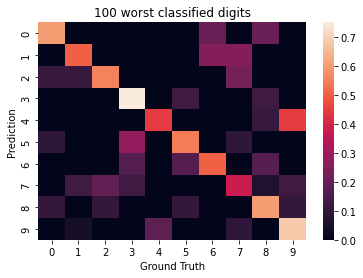

In [42]:
# Amount to show
n = 100
heat = np.zeros((10,10))

for i, truth, guess, con in arr[:n]:
    heat[int(truth), int(guess)] += 1

row_sums = heat.sum(axis=1)
heat = heat / row_sums[:, np.newaxis] 

ax = plt.axes()
sns.heatmap(heat, ax=ax)
ax.set_title(f'{n} worst classified digits')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

However, it still go the majority of these datapoints correct (Shown by the prominate diagonal line)

Least confident digits


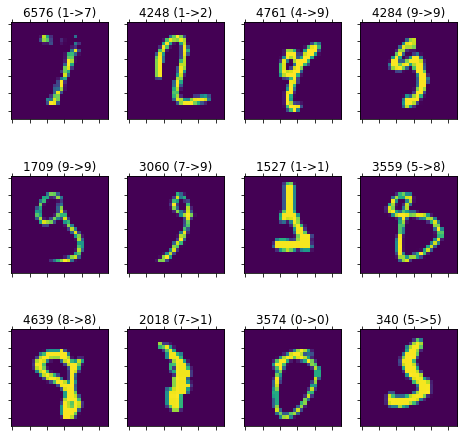

In [43]:
cols = 4
rows = 3
to_plot = arr[:, 0][:rows*cols].astype('int')
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

#fig.tight_layout()
cnt = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].matshow(x_test[to_plot[cnt]])
        axs[i, j].set_title(f'{to_plot[cnt]} ({int(arr[j+i*cols, 2])}->{int(arr[j+i*cols, 1])})')
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        cnt += 1
print("Least confident digits (Right and wrong)")
plt.show()

Legend: `ID (GUESS -> TRUTH)`

Some of the least confidence ids:
- 2754 (Really bad 6)
- 2836 (Doesn't really look like a number)
- 4886 (1 or 2 or 7 ?)

Most confident incorrect digits


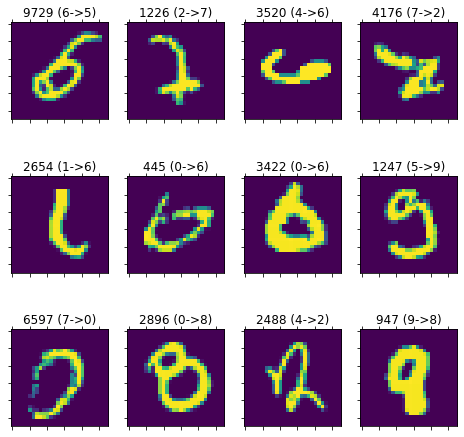

In [47]:
# Looking at all the digits that the classifier got wrong, which ones was it most confident about?
wrong = arr[arr[:,1] != arr[:,2]]
wrong = wrong[wrong[:,3].argsort()[::-1]]  # Set into descending order
cols = 4
rows = 3

wrong_indx = wrong[:, 0].astype('int')
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

#fig.tight_layout()
cnt = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].matshow(x_test[wrong_indx[cnt]])
        axs[i, j].set_title(f'{wrong_indx[cnt]} ({int(wrong[j+i*cols, 2])}->{int(wrong[j+i*cols, 1])})')
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        cnt += 1
print("Most confident incorrect digits")
plt.show()

These are the digits that the model was most confident about, but was wrong. Most of them are ambigious to me too. 

Examples
- 4176 (Looks like a scribble)
- 2035 (Contains both elements from 3 and 5)
- 3520 (Looks like neither a 4 nor 6)
- 2654 (Appears to be a 1 not a 6)
- 1247 (Looks like more of a G than a 5 or 9)

In [55]:
# Save the 10 most ambigious images to disk images to disk
img_folder = "imgs/"

for i in range(10):
    plt.imsave(img_folder + str(wrong_indx[i]) + ".jpg", x_test[wrong_indx[i]])